# Churn Customer Prediction

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Data Loading and Exploration

In [2]:
data = pd.read_csv('data/churn-train.csv', sep=',')

In [3]:
data.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1944,Female,1,No,No,31,Yes,Yes,'Fiber optic',No,No,No,No,No,No,Month-to-month,Yes,'Electronic check',73.90,2217.15,Yes
1613,Female,0,No,No,8,No,'No phone service',DSL,No,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',29.25,226.95,No
4594,Male,1,No,No,68,Yes,No,No,'No internet service','No internet service','No internet service','No internet service','No internet service','No internet service','Two year',Yes,'Credit card (automatic)',20.00,1396,No
1972,Male,0,Yes,No,71,Yes,No,No,'No internet service','No internet service','No internet service','No internet service','No internet service','No internet service','One year',No,'Electronic check',20.85,1539.75,No
1309,Female,0,Yes,Yes,37,Yes,Yes,No,'No internet service','No internet service','No internet service','No internet service','No internet service','No internet service','Two year',Yes,'Bank transfer (automatic)',24.10,861.85,No


In [4]:
data.shape

(4695, 20)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4695 non-null   object 
 1   SeniorCitizen     4695 non-null   int64  
 2   Partner           4695 non-null   object 
 3   Dependents        4695 non-null   object 
 4   tenure            4695 non-null   int64  
 5   PhoneService      4695 non-null   object 
 6   MultipleLines     4695 non-null   object 
 7   InternetService   4695 non-null   object 
 8   OnlineSecurity    4695 non-null   object 
 9   OnlineBackup      4695 non-null   object 
 10  DeviceProtection  4695 non-null   object 
 11  TechSupport       4695 non-null   object 
 12  StreamingTV       4695 non-null   object 
 13  StreamingMovies   4695 non-null   object 
 14  Contract          4695 non-null   object 
 15  PaperlessBilling  4695 non-null   object 
 16  PaymentMethod     4695 non-null   object 


In [6]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
data['Churn'].value_counts()

No     3443
Yes    1252
Name: Churn, dtype: int64

In [8]:
# Data Preprocessing
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4695 non-null   object 
 1   SeniorCitizen     4695 non-null   int64  
 2   Partner           4695 non-null   object 
 3   Dependents        4695 non-null   object 
 4   tenure            4695 non-null   int64  
 5   PhoneService      4695 non-null   object 
 6   MultipleLines     4695 non-null   object 
 7   InternetService   4695 non-null   object 
 8   OnlineSecurity    4695 non-null   object 
 9   OnlineBackup      4695 non-null   object 
 10  DeviceProtection  4695 non-null   object 
 11  TechSupport       4695 non-null   object 
 12  StreamingTV       4695 non-null   object 
 13  StreamingMovies   4695 non-null   object 
 14  Contract          4695 non-null   object 
 15  PaperlessBilling  4695 non-null   object 
 16  PaymentMethod     4695 non-null   object 


## Feature Selection

In [10]:
X_train = data.drop(['Churn'], axis=1)
y_train = data['Churn']

In [11]:
X_train.shape, y_train.shape

((4695, 19), (4695,))

In [12]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

In [13]:
X_train_cat.shape, X_train_num.shape

((4695, 15), (4695, 4))

In [14]:
X_train_cat.columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [15]:
X_train_num.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

### Chi-Square Test for categorical variables

In [16]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))

    chi_sq_results.setdefault('Feature', []).append(col)
    chi_sq_results.setdefault('p-value', []).append(round(pi, 10))


# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results.sort_values(by = 'p-value', ascending = True, ignore_index=True, inplace = True)

chi_sq_results

,Feature,p-value
0,Partner,0.000000
1,Dependents,0.000000
2,InternetService,0.000000
3,OnlineSecurity,0.000000
4,OnlineBackup,0.000000
5,DeviceProtection,0.000000
6,TechSupport,0.000000
7,StreamingTV,0.000000
8,StreamingMovies,0.000000
9,Contract,0.000000


### ANOVA F-Statisic for Numerical Variables

In [24]:
X_train_num.isna().sum()
# Fill the missing values with 0
X_train_num.fillna(0, inplace=True)

In [25]:
# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,tenure,659.861189,0.0
1,TotalCharges,191.298158,0.0
2,MonthlyCharges,174.211276,0.0
3,SeniorCitizen,129.537501,0.0


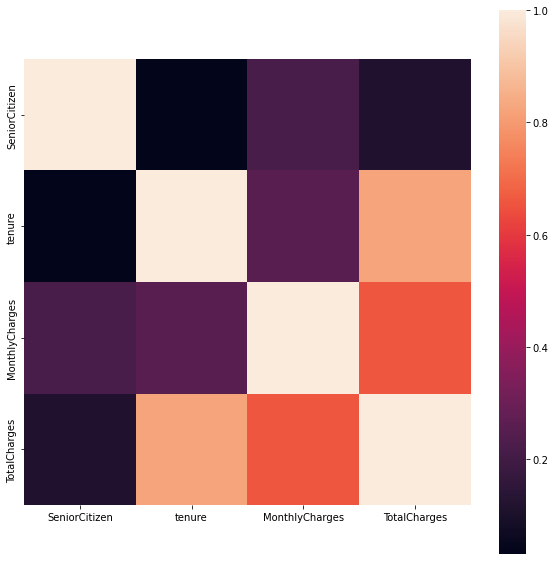

In [26]:
# Calculate the pair-wise correlations between the variables
corrmat = X_train_num.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True);

## Create Dummy Variables for categorical features

In [27]:
def create_dummy(df, column_list):
    df_dummies = []
    for col in column_list:
        df_dummies.append(pd.get_dummies(df[col], prefix=col, prefix_sep=':'))
    df_dummies = pd.concat(df_dummies, axis=1)
    df = pd.concat([df, df_dummies], axis=1)
    return df

In [28]:
X_train = create_dummy(X_train, X_train_cat.columns)

In [29]:
X_train.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender:Female,gender:Male,Partner:No,Partner:Yes,Dependents:No,Dependents:Yes,PhoneService:No,PhoneService:Yes,MultipleLines:'No phone service',MultipleLines:No,MultipleLines:Yes,InternetService:'Fiber optic',InternetService:DSL,InternetService:No,OnlineSecurity:'No internet service',OnlineSecurity:No,OnlineSecurity:Yes,OnlineBackup:'No internet service',OnlineBackup:No,OnlineBackup:Yes,DeviceProtection:'No internet service',DeviceProtection:No,DeviceProtection:Yes,TechSupport:'No internet service',TechSupport:No,TechSupport:Yes,StreamingTV:'No internet service',StreamingTV:No,StreamingTV:Yes,StreamingMovies:'No internet service',StreamingMovies:No,StreamingMovies:Yes,Contract:'One year',Contract:'Two year',Contract:Month-to-month,PaperlessBilling:No,PaperlessBilling:Yes,PaymentMethod:'Bank transfer (automatic)',PaymentMethod:'Credit card (automatic)',PaymentMethod:'Electronic check',PaymentMethod:'Mailed check'
2159,Female,0,No,No,8,Yes,No,DSL,Yes,No,No,Yes,No,Yes,Month-to-month,No,'Bank transfer (automatic)',66.05,574.50,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0
1371,Male,0,No,No,28,Yes,No,No,'No internet service','No internet service','No internet service','No internet service','No internet service','No internet service','One year',No,'Credit card (automatic)',18.25,534.70,0,1,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4034,Male,0,Yes,Yes,38,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,'One year',No,'Electronic check',74.05,2802.30,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0
244,Female,0,No,No,12,Yes,No,No,'No internet service','No internet service','No internet service','No internet service','No internet service','No internet service',Month-to-month,No,'Mailed check',19.45,246.25,1,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1
644,Male,0,No,No,12,No,'No phone service',DSL,No,Yes,No,Yes,No,No,Month-to-month,No,'Mailed check',34.00,442.45,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1


# Update the test-set with the same pre-processing steps as the training set

In [30]:
X_test = pd.read_csv('data/churn-test.csv', sep=',')

In [31]:
# X_test.sample(5)


In [32]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2348 non-null   object 
 1   SeniorCitizen     2348 non-null   int64  
 2   Partner           2348 non-null   object 
 3   Dependents        2348 non-null   object 
 4   tenure            2348 non-null   int64  
 5   PhoneService      2348 non-null   object 
 6   MultipleLines     2348 non-null   object 
 7   InternetService   2348 non-null   object 
 8   OnlineSecurity    2348 non-null   object 
 9   OnlineBackup      2348 non-null   object 
 10  DeviceProtection  2348 non-null   object 
 11  TechSupport       2348 non-null   object 
 12  StreamingTV       2348 non-null   object 
 13  StreamingMovies   2348 non-null   object 
 14  Contract          2348 non-null   object 
 15  PaperlessBilling  2348 non-null   object 
 16  PaymentMethod     2348 non-null   object 


In [33]:
# Data Preprocessing
X_test['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
X_test['Churn'] = X_test['Churn'].map({'Yes': 1, 'No': 0})

In [34]:
# Pre-processing test data
y_test = X_test['Churn']
X_test = X_test.drop(['Churn'], axis=1)

In [35]:
X_test_cat = X_test.select_dtypes(include = np.object).copy()

In [36]:
X_test = create_dummy(X_test, X_train_cat.columns)

In [37]:
X_test.shape, y_test.shape

((2348, 60), (2348,))

# Feature Engineering/Binning - Weight of Evidence (WoE) & Information Value (IV)

In [38]:
X_train_prep = X_train.copy()
X_test_prep = X_test.copy()
y_train_prep = y_train.copy()
y_test_prep = y_test.copy()

## Analyze WoE and IV of discrete features

In [39]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


sns.set()
# Function for plotting WoE across categoris that takes 2 arguments: a dataframe and a number
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = 'dotted', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    

In [40]:
# X_train_prep object type columns
X_train_cat.columns 

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

#### 

#### 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'

   gender  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  \
0    Male   2360   0.266525    0.502662   629.0  1731.0     0.502396   
1  Female   2335   0.266809    0.497338   623.0  1712.0     0.497604   

   prop_n_bad       WoE  diff_prop_good  diff_WoE            IV  
0    0.502759 -0.000722             NaN       NaN  5.272511e-07  
1    0.497241  0.000730        0.000284  0.001452  5.272511e-07  


  Partner  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  \
0     Yes   2250   0.196444    0.479233   442.0  1808.0     0.353035   
1      No   2445   0.331288    0.520767   810.0  1635.0     0.646965   

   prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0    0.525123 -0.397066             NaN       NaN  0.121546  
1    0.474877  0.309237        0.134844  0.706303  0.121546  


  Dependents  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  \
0        Yes   1375   0.157818    0.292865   217.0  1158.0     0.173323   
1         No   3320   0.3117

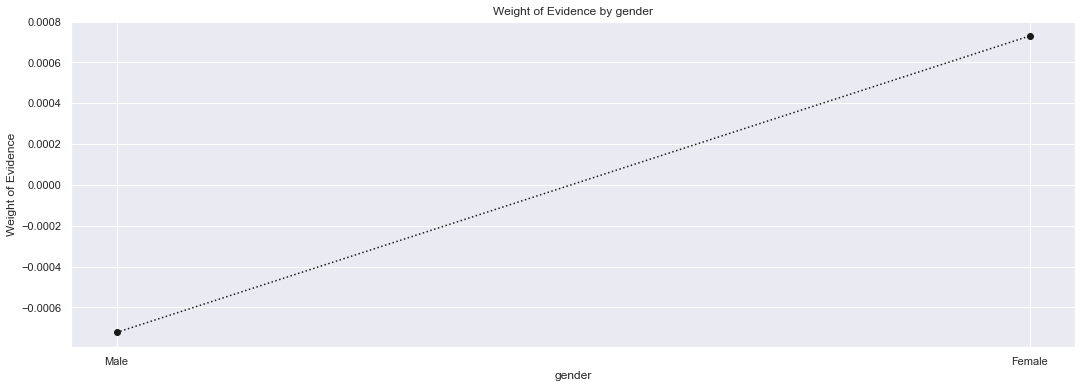

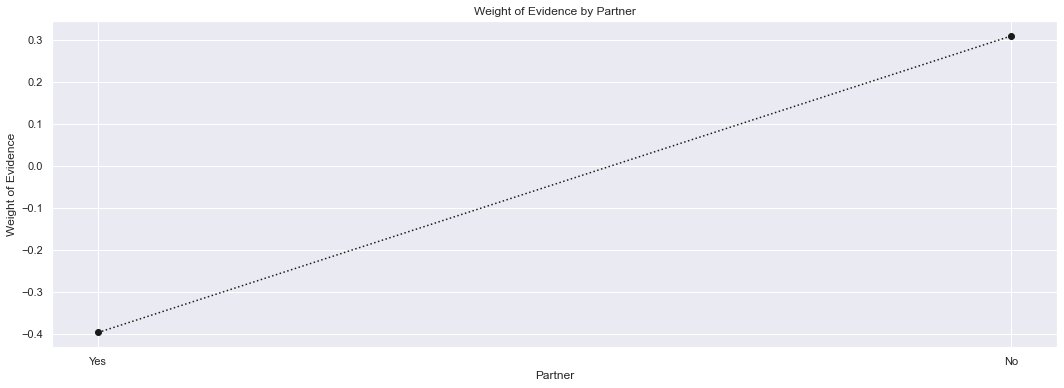

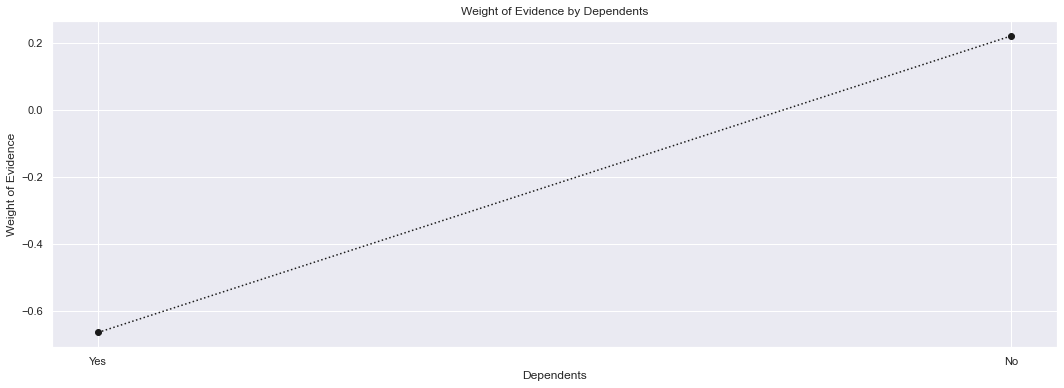

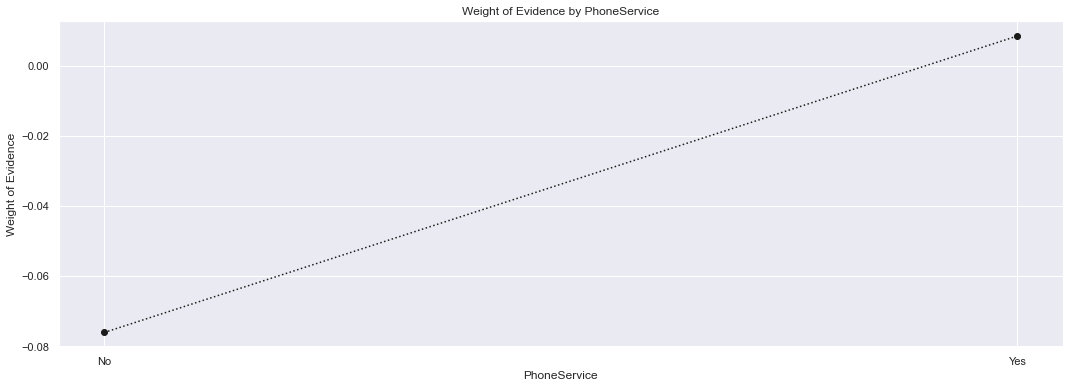

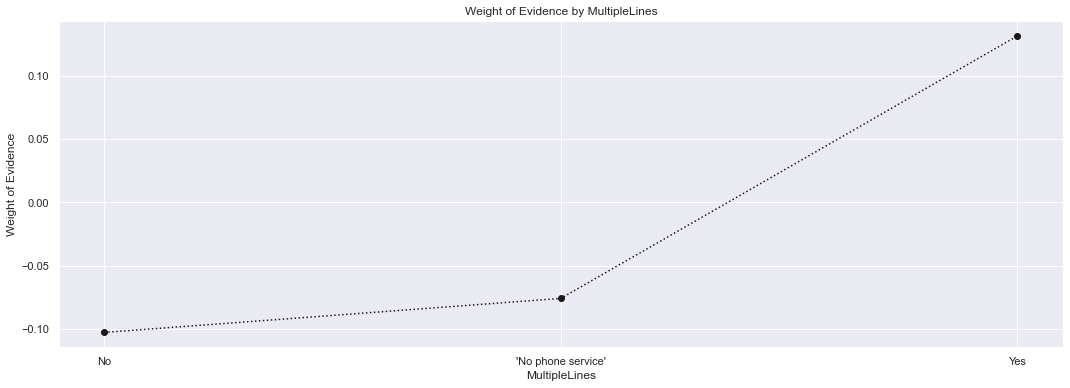

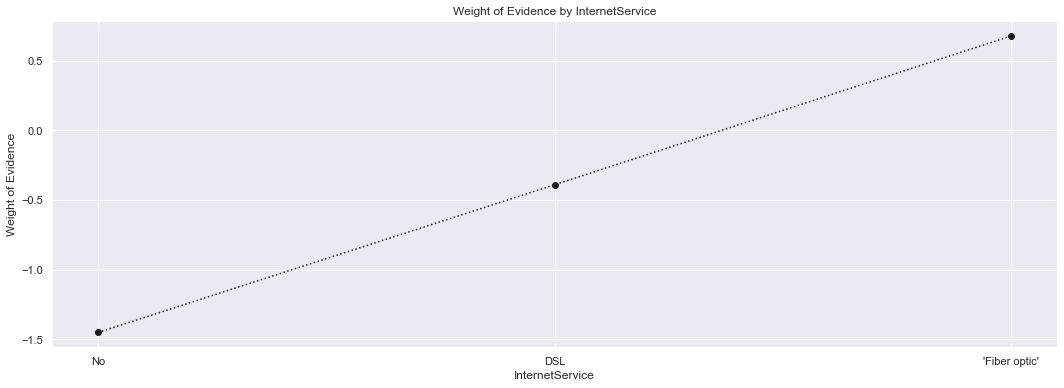

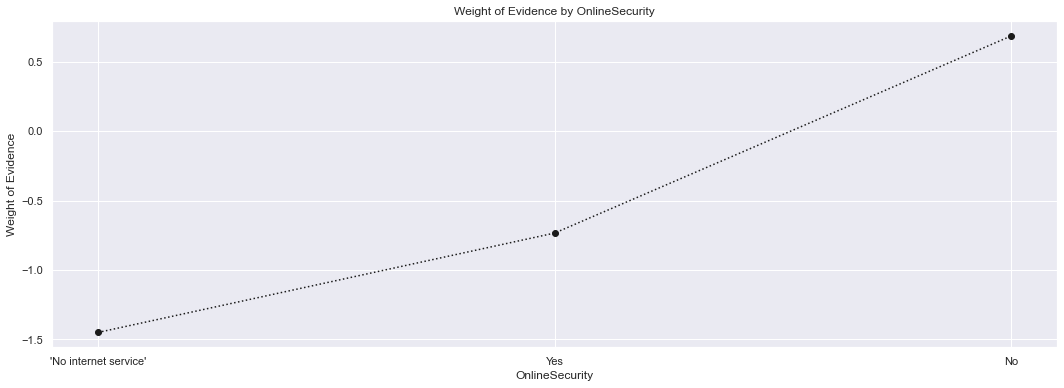

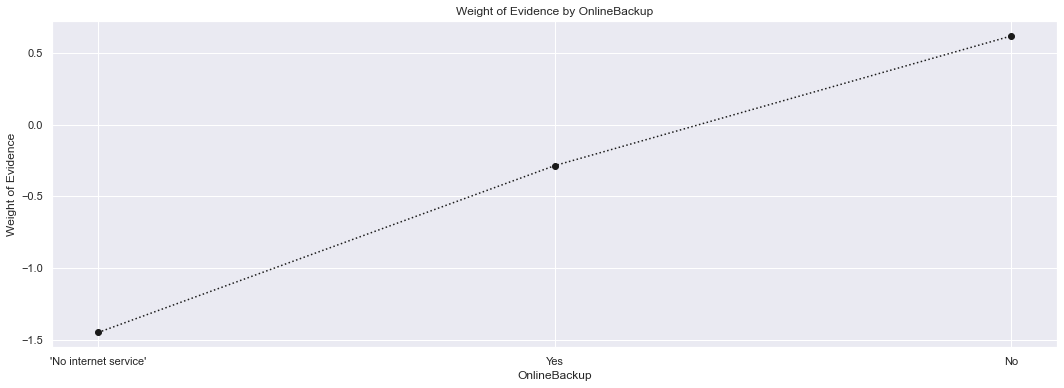

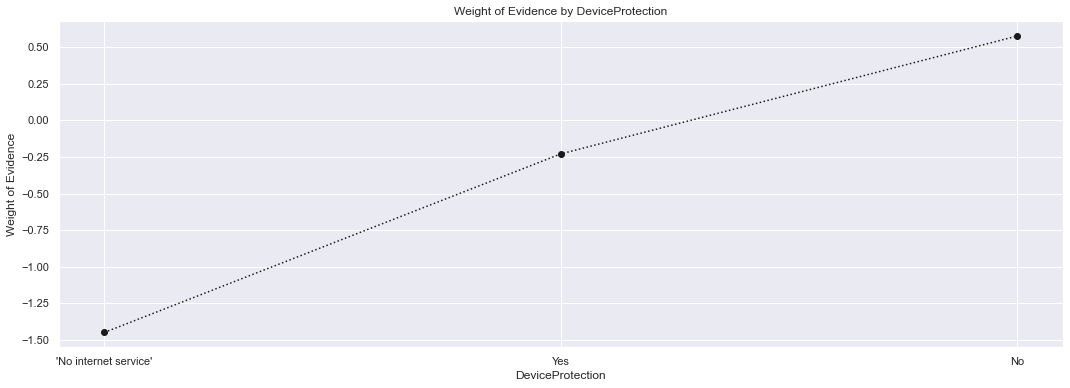

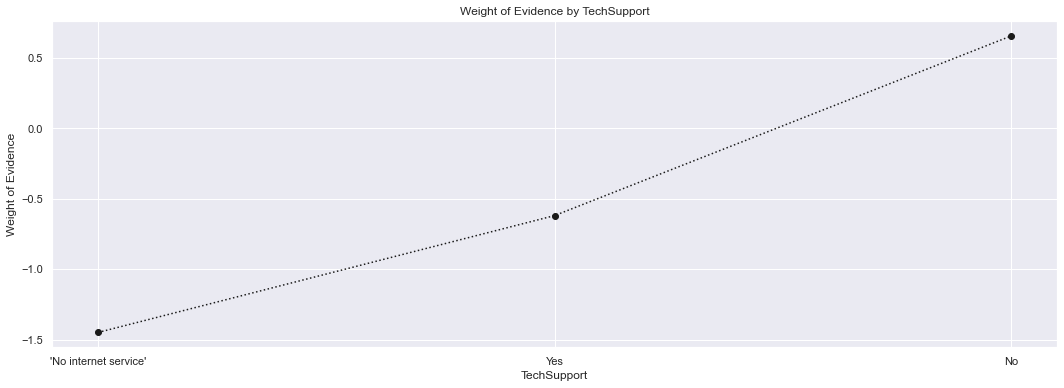

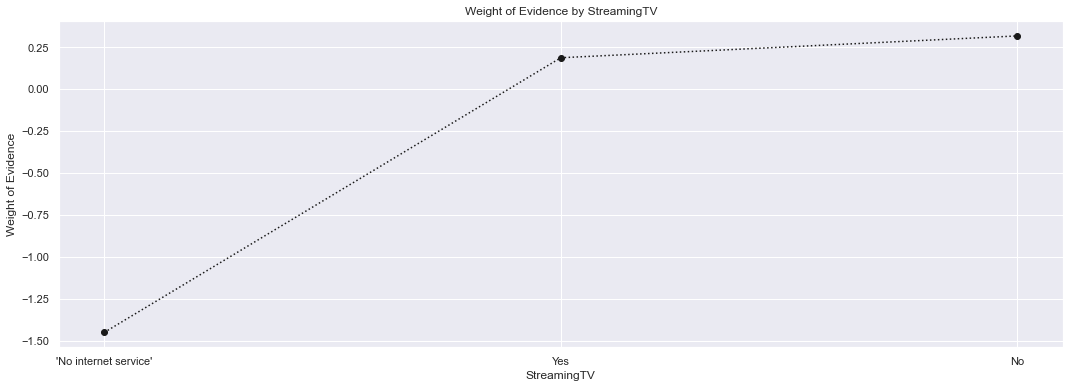

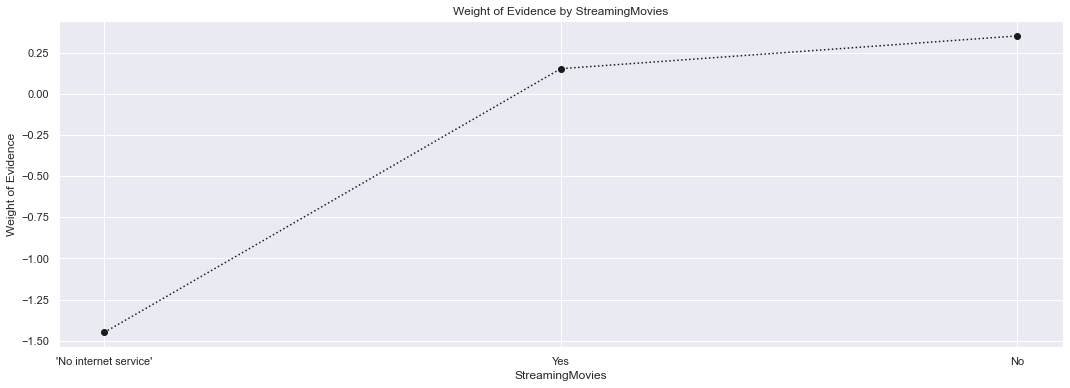

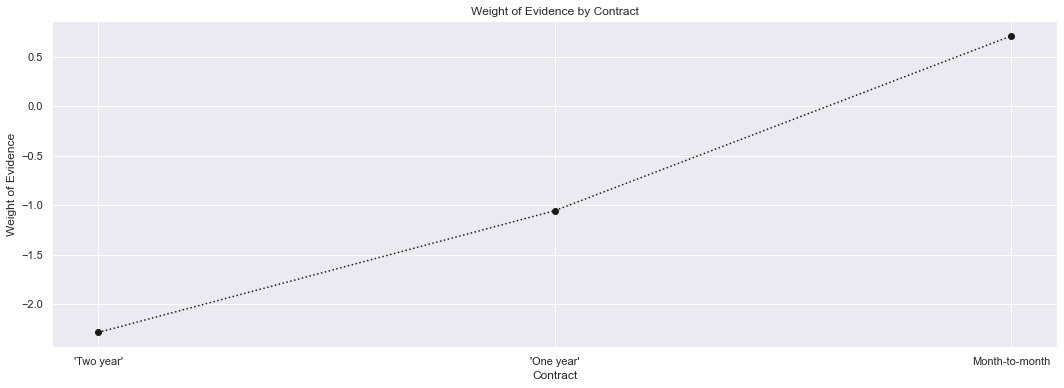

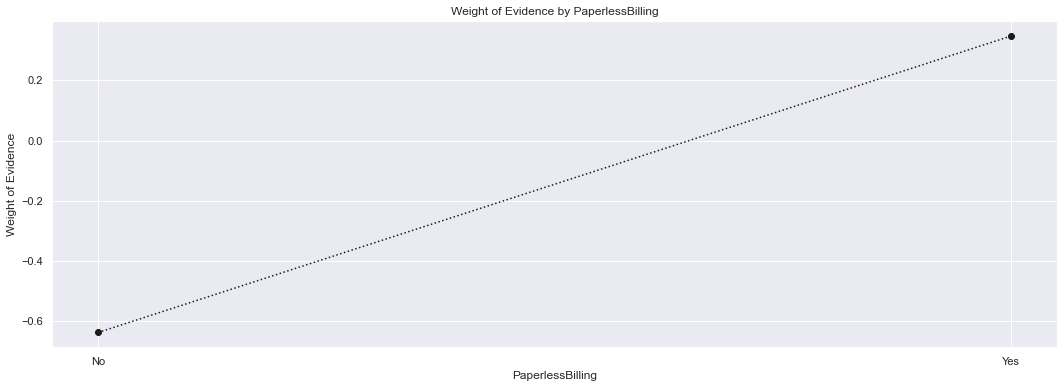

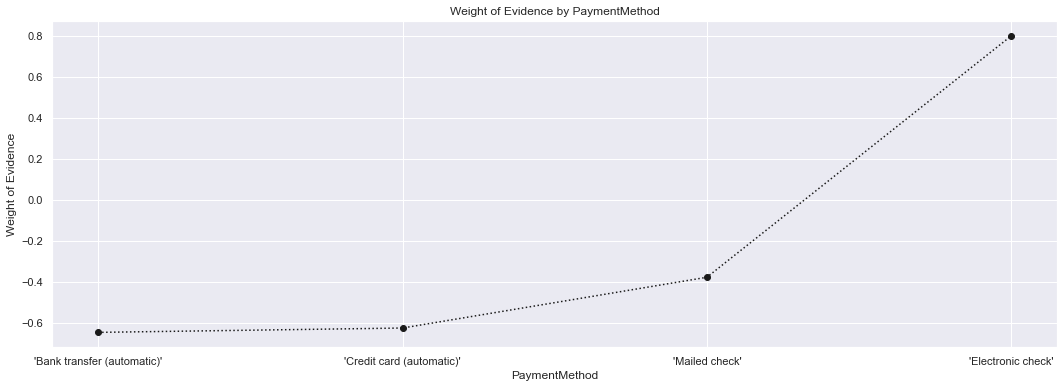

In [41]:
for col in X_train_cat.columns:
    df = woe_discrete(X_train_prep, col, y_train_prep)
    print(df)
    plot_by_woe(df)
    print('\n')

## Analyze WoE and IV of continuous features

In [42]:
X_train_num.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [43]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

#### 'SeniorCitizen'

In [44]:
X_train_prep['SeniorCitizen_factor'] = pd.cut(X_train_prep['SeniorCitizen'], 2)
df = woe_ordered_continuous(X_train_prep, 'SeniorCitizen_factor', y_train_prep)
df

,SeniorCitizen_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 0.5]",3929,0.234665,0.836848,922.0,3007.0,0.736422,0.873366,-0.170552,NaN,NaN,0.123744
1,"(0.5, 1.0]",766,0.430809,0.163152,330.0,436.0,0.263578,0.126634,0.733051,0.196144,0.903603,0.123744


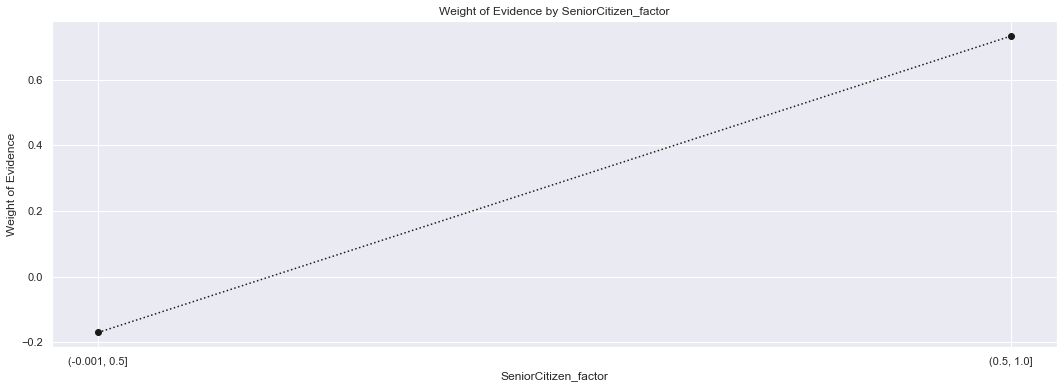

In [45]:
plot_by_woe(df)

#### 'tenure'

In [46]:
X_train_prep['tenure_factor'] = pd.cut(X_train_prep['tenure'], 10)
df = woe_ordered_continuous(X_train_prep, 'tenure_factor', y_train_prep)
df

,tenure_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.072, 7.2]",1075,0.521860,0.228967,561.0,514.0,0.448083,0.149288,1.099099,NaN,NaN,0.767901
1,"(7.2, 14.4]",510,0.343137,0.108626,175.0,335.0,0.139776,0.097299,0.362256,0.178723,0.736842,0.767901
2,"(14.4, 21.6]",384,0.276042,0.081789,106.0,278.0,0.084665,0.080744,0.047419,0.067096,0.314837,0.767901
3,"(21.6, 28.8]",370,0.232432,0.078807,86.0,284.0,0.068690,0.082486,-0.183026,0.043609,0.230445,0.767901
4,"(28.8, 36.0]",352,0.230114,0.074973,81.0,271.0,0.064696,0.078710,-0.196069,0.002319,0.013043,0.767901
5,"(36.0, 43.2]",310,0.232258,0.066028,72.0,238.0,0.057508,0.069126,-0.184004,0.002144,0.012065,0.767901
6,"(43.2, 50.4]",291,0.168385,0.061981,49.0,242.0,0.039137,0.070288,-0.585517,0.063873,0.401513,0.767901
7,"(50.4, 57.6]",338,0.142012,0.071991,48.0,290.0,0.038339,0.084229,-0.787079,0.026373,0.201562,0.767901
8,"(57.6, 64.8]",336,0.071429,0.071565,24.0,312.0,0.019169,0.090619,-1.553348,0.070583,0.766269,0.767901
9,"(64.8, 72.0]",729,0.068587,0.155272,50.0,679.0,0.039936,0.197212,-1.596997,0.002841,0.043649,0.767901


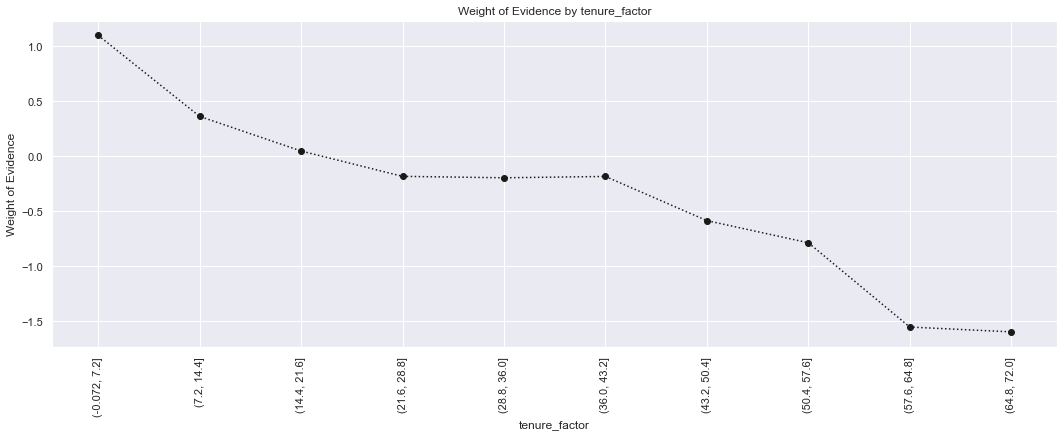

In [47]:
plot_by_woe(df, 90)

#### 'MonthlyCharges'

In [48]:
X_train_prep['MonthlyCharges_factor'] = pd.cut(X_train_prep['MonthlyCharges'], 10)
df = woe_ordered_continuous(X_train_prep, 'MonthlyCharges_factor', y_train_prep)
df

,MonthlyCharges_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(18.15, 28.3]",1091,0.098075,0.232375,107.0,984.0,0.085463,0.285797,-1.207196,NaN,NaN,0.458967
1,"(28.3, 38.35]",132,0.310606,0.028115,41.0,91.0,0.032748,0.026430,0.214313,0.212531,1.421510,0.458967
2,"(38.35, 48.4]",245,0.273469,0.052183,67.0,178.0,0.053514,0.051699,0.034510,0.037137,0.179803,0.458967
3,"(48.4, 58.45]",441,0.265306,0.093930,117.0,324.0,0.093450,0.094104,-0.006969,0.008163,0.041479,0.458967
4,"(58.45, 68.5]",317,0.123028,0.067519,39.0,278.0,0.031150,0.080744,-0.952459,0.142278,0.945490,0.458967
5,"(68.5, 78.55]",588,0.403061,0.125240,237.0,351.0,0.189297,0.101946,0.618875,0.280033,1.571333,0.458967
6,"(78.55, 88.6]",615,0.372358,0.130990,229.0,386.0,0.182907,0.112112,0.489486,0.030704,0.129389,0.458967
7,"(88.6, 98.65]",564,0.363475,0.120128,205.0,359.0,0.163738,0.104270,0.451289,0.008883,0.038197,0.458967
8,"(98.65, 108.7]",505,0.366337,0.107561,185.0,320.0,0.147764,0.092942,0.463636,0.002861,0.012347,0.458967
9,"(108.7, 118.75]",197,0.126904,0.041960,25.0,172.0,0.019968,0.049956,-0.917018,0.239433,1.380653,0.458967


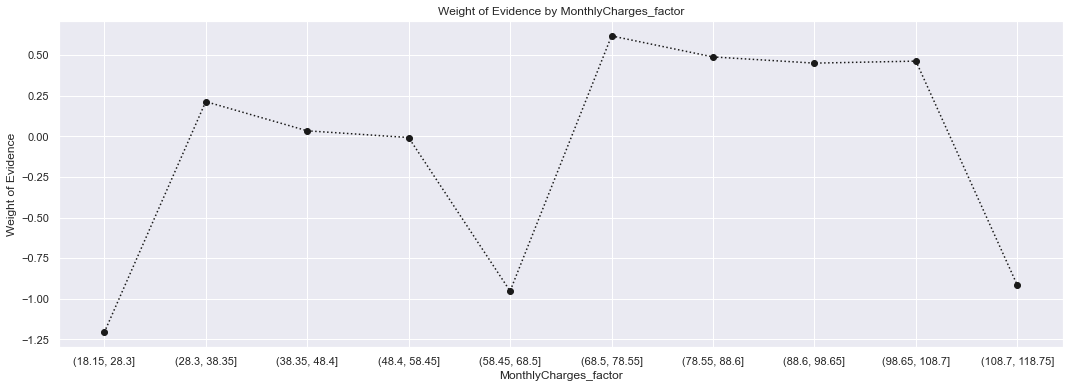

In [49]:
plot_by_woe(df)

#### 'TotalCharges'

In [50]:
X_train_prep['TotalCharges_factor'] = pd.cut(X_train_prep['TotalCharges'], 30)
df = woe_ordered_continuous(X_train_prep, 'TotalCharges_factor', y_train_prep)
df

,TotalCharges_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(10.184, 307.715]",1023,0.453568,0.218170,464.0,559.0,0.370607,0.162642,0.823592,NaN,NaN,0.37049
1,"(307.715, 596.58]",454,0.288546,0.096822,131.0,323.0,0.104633,0.093977,0.107402,0.165022,0.716190,0.37049
2,"(596.58, 885.445]",357,0.274510,0.076136,98.0,259.0,0.078275,0.075356,0.037996,0.014036,0.069406,0.37049
3,"(885.445, 1174.31]",305,0.272131,0.065046,83.0,222.0,0.066294,0.064591,0.026020,0.002379,0.011976,0.37049
4,"(1174.31, 1463.175]",287,0.174216,0.061207,50.0,237.0,0.039936,0.068955,-0.546180,0.097915,0.572200,0.37049
5,"(1463.175, 1752.04]",198,0.186869,0.042226,37.0,161.0,0.029553,0.046843,-0.460630,0.012653,0.085551,0.37049
6,"(1752.04, 2040.905]",187,0.165775,0.039881,31.0,156.0,0.024760,0.045388,-0.606012,0.021093,0.145382,0.37049
7,"(2040.905, 2329.77]",141,0.262411,0.030070,37.0,104.0,0.029553,0.030259,-0.023616,0.096636,0.582396,0.37049
8,"(2329.77, 2618.635]",136,0.323529,0.029004,44.0,92.0,0.035144,0.026768,0.272258,0.061118,0.295874,0.37049
9,"(2618.635, 2907.5]",111,0.306306,0.023672,34.0,77.0,0.027157,0.022403,0.192412,0.017223,0.079846,0.37049


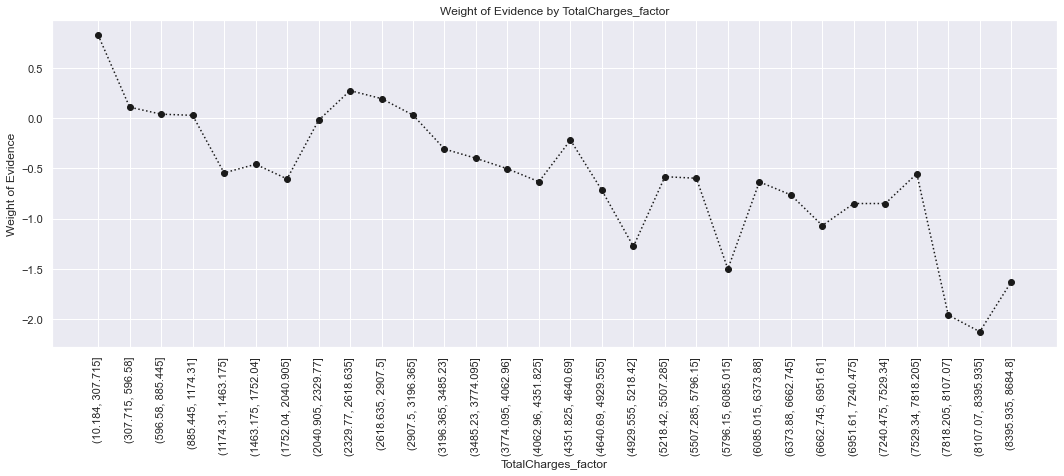

In [51]:
plot_by_woe(df, 90)

# WoE Binning and feature engineering

In [65]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['SeniorCitizen:0.5-1.0', 'tenure:>64.8', 'MonthlyCharges:>108.7', 'TotalCharges:>8395.307']

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ref_categories = []
        self.X = X_train
    
    def fit(self, X, y=None):
        self.ref_categories = X.columns.tolist()
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        # gender
        X_new['gender:Male'] = np.where(X_new['gender:Male'] == 1, 1, 0)
        X_new['gender:Female'] = np.where(X_new['gender:Female'] == 1, 1, 0) 

    
        # SeniorCitizen
        X_new['SeniorCitizen:-0.001-0.5'] = np.where((X_new['SeniorCitizen'] > -0.001) & (X_new['SeniorCitizen'] <= 0.5), 1, 0)
        X_new['SeniorCitizen:0.5-1.0'] = np.where((X_new['SeniorCitizen'] > 0.5), 1, 0)


        # tenure
        X_new['tenure:<7.2'] = np.where((X_new['tenure'] > -0.072) & (X_new['tenure'] <= 7.2), 1, 0)
        X_new['tenure:7.2-14.4	'] = np.where((X_new['tenure'] > 7.2) & (X_new['tenure'] <= 14.4), 1, 0)
        X_new['tenure:14.4-21.6'] = np.where((X_new['tenure'] > 14.4) & (X_new['tenure'] <= 21.6), 1, 0)
        X_new['tenure:21.6-28.8'] = np.where((X_new['tenure'] > 21.6) & (X_new['tenure'] <= 28.8), 1, 0)
        X_new['tenure:28.8-36.0'] = np.where((X_new['tenure'] > 28.8) & (X_new['tenure'] <= 36.0), 1, 0)
        X_new['tenure:36.0-43.2'] = np.where((X_new['tenure'] > 36.0) & (X_new['tenure'] <= 43.2), 1, 0)
        X_new['tenure:43.2-50.4'] = np.where((X_new['tenure'] > 43.2) & (X_new['tenure'] <= 50.4), 1, 0)
        X_new['tenure:50.4-57.6'] = np.where((X_new['tenure'] > 50.4) & (X_new['tenure'] <= 57.6), 1, 0)
        X_new['tenure:57.6-64.8'] = np.where((X_new['tenure'] > 57.6) & (X_new['tenure'] <= 64.8), 1, 0)
        X_new['tenure:>64.8'] = np.where((X_new['tenure'] > 64.8), 1, 0)
        
        # MonthlyCharges
        X_new['MonthlyCharges:<28.3'] = np.where((X_new['MonthlyCharges'] <= 28.3), 1, 0)  
        X_new['MonthlyCharges:28.3-38.35'] = np.where((X_new['MonthlyCharges'] > 28.3) & (X_new['MonthlyCharges'] <= 38.35), 1, 0)  
        X_new['MonthlyCharges:38.35-48.4'] = np.where((X_new['MonthlyCharges'] > 38.35) & (X_new['MonthlyCharges'] <= 48.4), 1, 0)
        X_new['MonthlyCharges:48.4-58.45'] = np.where((X_new['MonthlyCharges'] > 48.4) & (X_new['MonthlyCharges'] <= 58.45), 1, 0)
        X_new['MonthlyCharges:58.45-68.5'] = np.where((X_new['MonthlyCharges'] > 58.45) & (X_new['MonthlyCharges'] <= 68.5), 1, 0)
        X_new['MonthlyCharges:68.5-78.55'] = np.where((X_new['MonthlyCharges'] > 68.5) & (X_new['MonthlyCharges'] <= 78.55), 1, 0) 
        X_new['MonthlyCharges:78.55-88.6'] = np.where((X_new['MonthlyCharges'] > 78.55) & (X_new['MonthlyCharges'] <= 88.6), 1, 0)
        X_new['MonthlyCharges:88.6-98.65'] = np.where((X_new['MonthlyCharges'] > 88.6) & (X_new['MonthlyCharges'] <= 98.65), 1, 0)
        X_new['MonthlyCharges:98.65-108.7'] = np.where((X_new['MonthlyCharges'] > 98.65) & (X_new['MonthlyCharges'] <= 108.7), 1, 0)
        X_new['MonthlyCharges:>108.7'] = np.where((X_new['MonthlyCharges'] > 108.7), 1, 0)

        # TotalCharges
        X_new['TotalCharges:<289.493'] = np.where((X_new['TotalCharges'] <= 289.493), 1, 0)
        X_new['TotalCharges:289.493-578.987'] = np.where((X_new['TotalCharges'] > 289.493) & (X_new['TotalCharges'] <= 578.987), 1, 0)
        X_new['TotalCharges:578.987-868.48'] = np.where((X_new['TotalCharges'] > 578.987) & (X_new['TotalCharges'] <= 868.48), 1, 0)
        X_new['TotalCharges:868.48-1157.973'] = np.where((X_new['TotalCharges'] > 868.48) & (X_new['TotalCharges'] <= 1157.973), 1, 0)
        X_new['TotalCharges:1157.973-1447.467'] = np.where((X_new['TotalCharges'] > 1157.973) & (X_new['TotalCharges'] <= 1447.467), 1, 0)
        X_new['TotalCharges:1447.467-1736.96'] = np.where((X_new['TotalCharges'] > 1447.467) & (X_new['TotalCharges'] <= 1736.96), 1, 0)
        X_new['TotalCharges:1736.96-2026.453'] = np.where((X_new['TotalCharges'] > 1736.96) & (X_new['TotalCharges'] <= 2026.453), 1, 0)
        X_new['TotalCharges:2026.453-2315.947'] = np.where((X_new['TotalCharges'] > 2026.453) & (X_new['TotalCharges'] <= 2315.947), 1, 0)
        X_new['TotalCharges:2315.947-2605.44'] = np.where((X_new['TotalCharges'] > 2315.947) & (X_new['TotalCharges'] <= 2605.44), 1, 0)
        X_new['TotalCharges:2605.44-2894.933'] = np.where((X_new['TotalCharges'] > 2605.44) & (X_new['TotalCharges'] <= 2894.933), 1, 0)
        X_new['TotalCharges:2894.933-3184.427'] = np.where((X_new['TotalCharges'] > 2894.933) & (X_new['TotalCharges'] <= 3184.427), 1, 0)
        X_new['TotalCharges:3184.427-3473.92'] = np.where((X_new['TotalCharges'] > 3184.427) & (X_new['TotalCharges'] <= 3473.92), 1, 0)
        X_new['TotalCharges:3473.92-3763.413'] = np.where((X_new['TotalCharges'] > 3473.92) & (X_new['TotalCharges'] <= 3763.413), 1, 0)
        X_new['TotalCharges:3763.413-4052.907'] = np.where((X_new['TotalCharges'] > 3763.413) & (X_new['TotalCharges'] <= 4052.907), 1, 0)
        X_new['TotalCharges:4052.907-4342.4'] = np.where((X_new['TotalCharges'] > 4052.907) & (X_new['TotalCharges'] <= 4342.4), 1, 0)
        X_new['TotalCharges:4342.4-4631.893'] = np.where((X_new['TotalCharges'] > 4342.4) & (X_new['TotalCharges'] <= 4631.893), 1, 0)
        X_new['TotalCharges:4631.893-4921.387'] = np.where((X_new['TotalCharges'] > 4631.893) & (X_new['TotalCharges'] <= 4921.387), 1, 0)
        X_new['TotalCharges:4921.387-5210.88'] = np.where((X_new['TotalCharges'] > 4921.387) & (X_new['TotalCharges'] <= 5210.88), 1, 0)
        X_new['TotalCharges:5210.88-5500.373'] = np.where((X_new['TotalCharges'] > 5210.88) & (X_new['TotalCharges'] <= 5500.373), 1, 0)
        X_new['TotalCharges:5500.373-5789.867'] = np.where((X_new['TotalCharges'] > 5500.373) & (X_new['TotalCharges'] <= 5789.867), 1, 0)
        X_new['TotalCharges:5789.867-6079.36'] = np.where((X_new['TotalCharges'] > 5789.867) & (X_new['TotalCharges'] <= 6079.36), 1, 0)
        X_new['TotalCharges:6079.36-6368.853'] = np.where((X_new['TotalCharges'] > 6079.36) & (X_new['TotalCharges'] <= 6368.853), 1, 0)
        X_new['TotalCharges:6368.853-6658.347'] = np.where((X_new['TotalCharges'] > 6368.853) & (X_new['TotalCharges'] <= 6658.347), 1, 0)
        X_new['TotalCharges:6658.347-6947.84'] = np.where((X_new['TotalCharges'] > 6658.347) & (X_new['TotalCharges'] <= 6947.84), 1, 0)
        X_new['TotalCharges:6947.84-7237.333'] = np.where((X_new['TotalCharges'] > 6947.84) & (X_new['TotalCharges'] <= 7237.333), 1, 0)
        X_new['TotalCharges:7237.333-7526.827'] = np.where((X_new['TotalCharges'] > 7237.333) & (X_new['TotalCharges'] <= 7526.827), 1, 0)
        X_new['TotalCharges:7526.827-7816.32'] = np.where((X_new['TotalCharges'] > 7526.827) & (X_new['TotalCharges'] <= 7816.32), 1, 0)
        X_new['TotalCharges:7816.32-8105.813'] = np.where((X_new['TotalCharges'] > 7816.32) & (X_new['TotalCharges'] <= 8105.813), 1, 0)
        X_new['TotalCharges:8105.813-8395.307'] = np.where((X_new['TotalCharges'] > 8105.813) & (X_new['TotalCharges'] <= 8395.307), 1, 0)
        X_new['TotalCharges:>8395.307'] = np.where((X_new['TotalCharges'] > 8395.307), 1, 0)

        X_new.drop(columns = self.ref_categories, inplace = True)
        return X_new

In [66]:
from sklearn.linear_model import LogisticRegression

woe_binning = WoE_Binning()

pipeline = Pipeline(steps = [('woe_binning', woe_binning),
                                ('model', LogisticRegression(max_iter = 1000, class_weight='balanced'))
                                ])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
AUROC = np.mean(scores)
print('Mean AUROC: %.4f' % AUROC)

Mean AUROC: 0.8127


In [135]:
# Accuracy score
scores = cross_val_score(pipeline, X_train_prep, y_train_prep, scoring='accuracy', cv=cv, n_jobs=-1)
accuracy = np.mean(scores)
print('Mean Accuracy: %.4f' % accuracy)

Mean Accuracy: nan


In [106]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe_binning', WoE_Binning()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [107]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_binning.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,-0.400853
1,SeniorCitizen:-0.001-0.5,-0.378053
2,SeniorCitizen:0.5-1.0,0.374313
3,tenure:<7.2,1.803673
4,tenure:7.2-14.4\t,0.809969
5,tenure:14.4-21.6,0.593139
6,tenure:21.6-28.8,0.101543
7,tenure:28.8-36.0,-0.083043
8,tenure:36.0-43.2,0.131845
9,tenure:43.2-50.4,-0.200626


In [108]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [109]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(2348, 2)

In [110]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
0,0,0.717637
1,0,0.237004
2,1,0.649572
3,0,0.191547
4,1,0.839910


In [112]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimal threshold later
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.5306644 , 0.20655877],
       [0.06601363, 0.1967632 ]])

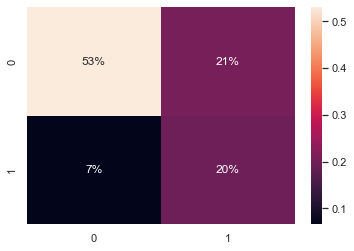

In [113]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')
sns.heatmap(cm, annot=True, fmt=".0%")
plt.show()

In [114]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'])

0.727427597955707

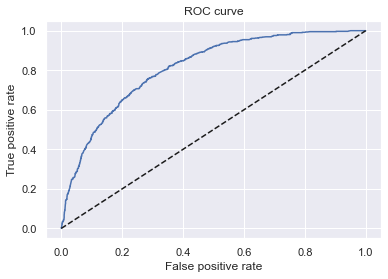

In [115]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [116]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.8126489311599799

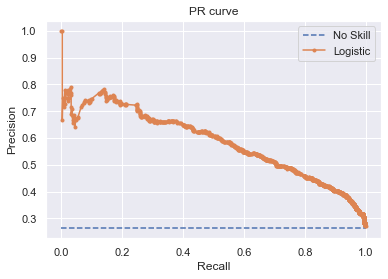

In [121]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [122]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.5860980868828078